In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm 

from sklearn.decomposition import PCA #Regularization

from sklearn import metrics

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%matplotlib inline

## What is the most optimal Wordle starting guess that gives you the best chance of getting at least two correct letters (either in the right or wrong places) after your first guess?

#### Load in and understand the data

In [2]:
wordle = pd.read_csv('/Users/christophergaldi/DataAnalyticsLiaison-Assignment-Jan2021/Wordle_Mystery_Words.csv')
wordle.head(10) #loading in "mystery words" and looking at the first 10

,Word
0,aback
1,abase
2,abate
3,abbey
4,abbot
5,abhor
6,abide
7,abled
8,abode
9,abort


In [3]:
wordle.describe()

,Word
count,2315
unique,2315
top,intro
freq,1


In [4]:
wordle.describe().columns #Determing data type of column

Index(['Word'], dtype='object')

In [5]:
wordle.isnull().sum(axis = 0) # Checking if there are any null values

Word    0
dtype: int64

#### Break apart the "mystery words" for analysis

In [6]:
def split(word):
    return [char for char in word]

In [7]:
letterswordle = wordle.apply(lambda x:split(x[0]), axis = 1, result_type = 'expand')
letterswordle.columns = ["1stLetter", "2ndLetter", "3rdLetter", "4thLetter", "5thLetter"]

In [8]:
letterswordle.head(5) #new dataframe with mystery words split apart by letter

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
0,a,b,a,c,k
1,a,b,a,s,e
2,a,b,a,t,e
3,a,b,b,e,y
4,a,b,b,o,t


In [9]:
letterswordle = letterswordle.apply(lambda x: x.astype(str).str.upper()) #for readability, changed the letters to upper case

In [10]:
letterswordle.head(5)

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
0,A,B,A,C,K
1,A,B,A,S,E
2,A,B,A,T,E
3,A,B,B,E,Y
4,A,B,B,O,T


#### Analyze the frequency and probability of the mystery words for each position and overall letters in each position

In [11]:
frequency = letterswordle.apply(pd.Series.value_counts) #gets a new dataframe with the count of each letter per position
frequency = frequency.fillna(0)
frequency.head(5)

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
A,141.0,304,307,163.0,64.0
B,173.0,16,57,24.0,11.0
C,198.0,40,56,152.0,31.0
D,111.0,20,75,69.0,118.0
E,72.0,242,177,318.0,424.0


##### Frequency of First Letter

In [12]:
frequency1 = frequency.sort_values('1stLetter', ascending = False) #sorting dataframe by the highest frequency of letters in the first position
frequency1

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
S,366.0,16,80,171.0,36.0
C,198.0,40,56,152.0,31.0
B,173.0,16,57,24.0,11.0
T,149.0,77,111,139.0,253.0
P,142.0,61,58,50.0,56.0
A,141.0,304,307,163.0,64.0
F,136.0,8,25,35.0,26.0
G,115.0,12,67,76.0,41.0
D,111.0,20,75,69.0,118.0
M,107.0,38,61,68.0,42.0


In [13]:
frequency1['1stLetter'].describe()

count     26.000000
mean      89.038462
std       79.705197
min        0.000000
25%       33.250000
50%       77.500000
75%      130.750000
max      366.000000
Name: 1stLetter, dtype: float64

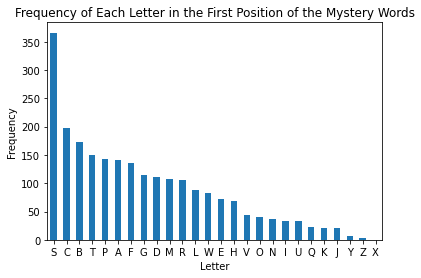

In [14]:
frequency1["1stLetter"].plot.bar()
plt.title("Frequency of Each Letter in the First Position of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter in the first position is "S". The top five are "S", "C", "B", "T", and "P", with the least common letters being "K", "J", "Y", "Z", and lastly, "X". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of Each Letter in the 1st Position

In [15]:
frequency1['Probability1'] = ((frequency1['1stLetter']/2315))
frequency1

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability1
S,366.0,16,80,171.0,36.0,0.158099
C,198.0,40,56,152.0,31.0,0.085529
B,173.0,16,57,24.0,11.0,0.074730
T,149.0,77,111,139.0,253.0,0.064363
P,142.0,61,58,50.0,56.0,0.061339
A,141.0,304,307,163.0,64.0,0.060907
F,136.0,8,25,35.0,26.0,0.058747
G,115.0,12,67,76.0,41.0,0.049676
D,111.0,20,75,69.0,118.0,0.047948
M,107.0,38,61,68.0,42.0,0.046220


In [16]:
frequency1['Probability1'].std() #Calculate Standard Deviation of Probability of 1st Position

0.03442989080143279

In [17]:
frequency1['Probability1'].var() #Calculate Variance of Probability of 1st Position

0.0011854173805985865

##### Frequency of Second Letter

In [18]:
frequency2 = frequency.sort_values('2ndLetter', ascending = False)
frequency2

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
A,141.0,304,307,163.0,64.0
O,41.0,279,244,132.0,58.0
R,105.0,267,163,152.0,212.0
E,72.0,242,177,318.0,424.0
I,34.0,202,266,158.0,11.0
L,88.0,201,112,162.0,156.0
U,33.0,186,165,82.0,1.0
H,69.0,144,9,28.0,139.0
N,37.0,87,139,182.0,130.0
T,149.0,77,111,139.0,253.0


In [19]:
frequency2['2ndLetter'].describe()

count     26.000000
mean      89.038462
std      100.980188
min        2.000000
25%       14.250000
50%       39.000000
75%      175.500000
max      304.000000
Name: 2ndLetter, dtype: float64

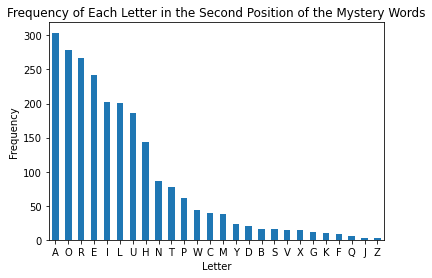

In [20]:
frequency2["2ndLetter"].plot.bar()
plt.title("Frequency of Each Letter in the Second Position of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter in the second position is "A". The top five are "A", "O", "R", "E", and "I", with the least common letters being "K", "F", "Q", "J", and lastly, "Z". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of Each Letter in the 2nd Position

In [21]:
frequency2['Probability2'] = ((frequency2['2ndLetter']/2315))
frequency2

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability2
A,141.0,304,307,163.0,64.0,0.131317
O,41.0,279,244,132.0,58.0,0.120518
R,105.0,267,163,152.0,212.0,0.115335
E,72.0,242,177,318.0,424.0,0.104536
I,34.0,202,266,158.0,11.0,0.087257
L,88.0,201,112,162.0,156.0,0.086825
U,33.0,186,165,82.0,1.0,0.080346
H,69.0,144,9,28.0,139.0,0.062203
N,37.0,87,139,182.0,130.0,0.037581
T,149.0,77,111,139.0,253.0,0.033261


In [22]:
frequency2['Probability2'].std() #Calculate Standard Deviation of Probability of 2nd Position

0.04361995181883405

In [23]:
frequency2['Probability2'].var() #Calculate Variance of Probability of 2nd Position

0.001902700196677404

##### Frequency of Third Letter

In [24]:
frequency3 = frequency.sort_values('3rdLetter', ascending = False)
frequency3

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
A,141.0,304,307,163.0,64.0
I,34.0,202,266,158.0,11.0
O,41.0,279,244,132.0,58.0
E,72.0,242,177,318.0,424.0
U,33.0,186,165,82.0,1.0
R,105.0,267,163,152.0,212.0
N,37.0,87,139,182.0,130.0
L,88.0,201,112,162.0,156.0
T,149.0,77,111,139.0,253.0
S,366.0,16,80,171.0,36.0


In [25]:
frequency3['3rdLetter'].describe()

count     26.000000
mean      89.038462
std       85.499231
min        1.000000
25%       25.250000
50%       59.500000
75%      132.250000
max      307.000000
Name: 3rdLetter, dtype: float64

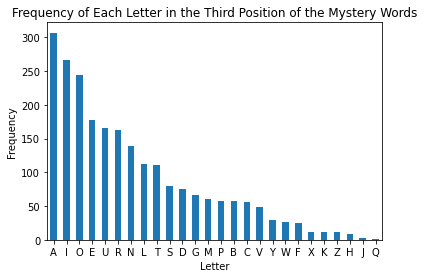

In [26]:
frequency3['3rdLetter'].plot.bar()
plt.title("Frequency of Each Letter in the Third Position of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter in the third position is "A". The top five are "A", "I", "O", "E", and "U", with the least common letters being "K", "Z", "H", "J", and lastly, "Q". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of Each Letter in the 3rd Position

In [27]:
frequency3['Probability3'] = ((frequency3['3rdLetter']/2315))
frequency3

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability3
A,141.0,304,307,163.0,64.0,0.132613
I,34.0,202,266,158.0,11.0,0.114903
O,41.0,279,244,132.0,58.0,0.105400
E,72.0,242,177,318.0,424.0,0.076458
U,33.0,186,165,82.0,1.0,0.071274
R,105.0,267,163,152.0,212.0,0.070410
N,37.0,87,139,182.0,130.0,0.060043
L,88.0,201,112,162.0,156.0,0.048380
T,149.0,77,111,139.0,253.0,0.047948
S,366.0,16,80,171.0,36.0,0.034557


In [28]:
frequency3['Probability3'].std() #Calculate Standard Deviation of Probability of 3rd Position

0.036932713073766915

In [29]:
frequency3['Probability3'].var() #Calculate Variance of Probability of 3rd Position

0.0013640252949891937

##### Frequency of Fourth Letter

In [30]:
frequency4 = frequency.sort_values('4thLetter', ascending = False)
frequency4

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
E,72.0,242,177,318.0,424.0
N,37.0,87,139,182.0,130.0
S,366.0,16,80,171.0,36.0
A,141.0,304,307,163.0,64.0
L,88.0,201,112,162.0,156.0
I,34.0,202,266,158.0,11.0
R,105.0,267,163,152.0,212.0
C,198.0,40,56,152.0,31.0
T,149.0,77,111,139.0,253.0
O,41.0,279,244,132.0,58.0


In [31]:
frequency4['4thLetter'].describe()

count     26.000000
mean      89.038462
std       77.782507
min        0.000000
25%       25.750000
50%       68.500000
75%      152.000000
max      318.000000
Name: 4thLetter, dtype: float64

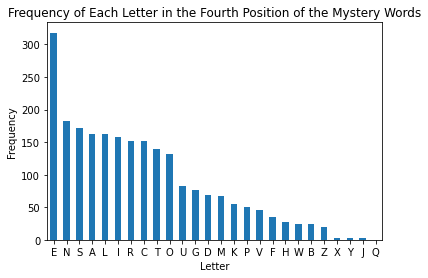

In [32]:
frequency4["4thLetter"].plot.bar()
plt.title("Frequency of Each Letter in the Fourth Position of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter in the fourth position is "E". The top five are "E", "N", "S", "A", and "L", with the least common letters being "Z", "X", "Y", "J", and lastly, "Q". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of Each Letter in the 4th Position

In [33]:
frequency4['Probability4'] = ((frequency4['4thLetter']/2315))
frequency4

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability4
E,72.0,242,177,318.0,424.0,0.137365
N,37.0,87,139,182.0,130.0,0.078618
S,366.0,16,80,171.0,36.0,0.073866
A,141.0,304,307,163.0,64.0,0.070410
L,88.0,201,112,162.0,156.0,0.069978
I,34.0,202,266,158.0,11.0,0.068251
R,105.0,267,163,152.0,212.0,0.065659
C,198.0,40,56,152.0,31.0,0.065659
T,149.0,77,111,139.0,253.0,0.060043
O,41.0,279,244,132.0,58.0,0.057019


In [34]:
frequency4['Probability4'].std() #Calculate Variance of Standard Deviation of 4th Position

0.03359935525978538

In [35]:
frequency4['Probability4'].var() #Calculate Variance of Probability of 4th Position

0.0011289166738732673

##### Freqeuncy of Fifth Letter

In [36]:
frequency5 = frequency.sort_values('5thLetter', ascending = False)
frequency5

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter
E,72.0,242,177,318.0,424.0
Y,6.0,23,29,3.0,364.0
T,149.0,77,111,139.0,253.0
R,105.0,267,163,152.0,212.0
L,88.0,201,112,162.0,156.0
H,69.0,144,9,28.0,139.0
N,37.0,87,139,182.0,130.0
D,111.0,20,75,69.0,118.0
K,20.0,10,12,55.0,113.0
A,141.0,304,307,163.0,64.0


In [37]:
frequency5['5thLetter'].describe()

count     26.000000
mean      89.038462
std      113.125941
min        0.000000
25%       11.000000
50%       41.500000
75%      127.000000
max      424.000000
Name: 5thLetter, dtype: float64

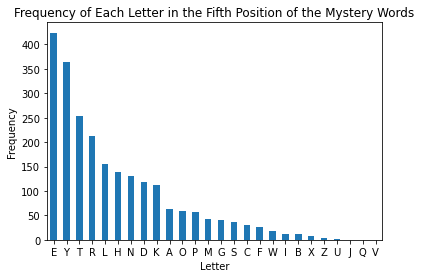

In [38]:
frequency5['5thLetter'].plot.bar()
plt.title("Frequency of Each Letter in the Fifth Position of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter in the fifth position is "E". The top five are "E", "Y", "T", "R", and "L", with the least common letters being "Z", "U", "J", "Q", and lastly, "V". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of each letter in the 5th Position

In [39]:
frequency5['Probability5'] = ((frequency5['5thLetter']/2315))
frequency5

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability5
E,72.0,242,177,318.0,424.0,0.183153
Y,6.0,23,29,3.0,364.0,0.157235
T,149.0,77,111,139.0,253.0,0.109287
R,105.0,267,163,152.0,212.0,0.091577
L,88.0,201,112,162.0,156.0,0.067387
H,69.0,144,9,28.0,139.0,0.060043
N,37.0,87,139,182.0,130.0,0.056156
D,111.0,20,75,69.0,118.0,0.050972
K,20.0,10,12,55.0,113.0,0.048812
A,141.0,304,307,163.0,64.0,0.027646


In [40]:
frequency5['Probability5'].std() #Calculate Variance of Probability of 5th Position

0.048866497066985246

In [41]:
frequency5['Probability5'].var() #Calculate Variance of Probability of 5th Position

0.0023879345355976773

##### Frequency of All Letters

In [42]:
Tfrequency = frequency
Tfrequency['Total'] = Tfrequency.sum(1)
Tfrequency = Tfrequency.sort_values('Total', ascending = False)
Tfrequency

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Total
E,72.0,242,177,318.0,424.0,1233.0
A,141.0,304,307,163.0,64.0,979.0
R,105.0,267,163,152.0,212.0,899.0
O,41.0,279,244,132.0,58.0,754.0
T,149.0,77,111,139.0,253.0,729.0
L,88.0,201,112,162.0,156.0,719.0
I,34.0,202,266,158.0,11.0,671.0
S,366.0,16,80,171.0,36.0,669.0
N,37.0,87,139,182.0,130.0,575.0
C,198.0,40,56,152.0,31.0,477.0


In [43]:
Tfrequency['Total'].describe()

count      26.000000
mean      445.192308
std       315.238833
min        27.000000
25%       215.000000
50%       391.000000
75%       670.500000
max      1233.000000
Name: Total, dtype: float64

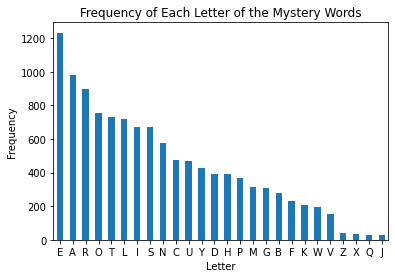

In [44]:
Tfrequency['Total'].plot.bar()
plt.title("Frequency of Each Letter of the Mystery Words")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

The most common letter is "E". The top five are "E", "A", "R", "O", and "T", with the least common letters being "V", "Z", "X", "Q", and lastly, "J". To determine our final list, we will include the top five in our sample set to determine which letters may be used in the most optimized list.

##### Probability of Each Letter Being Contained in the Mystery Word

In [45]:
Tfrequency['TProbability'] = ((Tfrequency['Total']/(5 * 2315))) # To find the total number of letters in all 2315 5-letter words
Tfrequency

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Total,TProbability
E,72.0,242,177,318.0,424.0,1233.0,0.106523
A,141.0,304,307,163.0,64.0,979.0,0.084579
R,105.0,267,163,152.0,212.0,899.0,0.077667
O,41.0,279,244,132.0,58.0,754.0,0.065140
T,149.0,77,111,139.0,253.0,729.0,0.062981
L,88.0,201,112,162.0,156.0,719.0,0.062117
I,34.0,202,266,158.0,11.0,671.0,0.057970
S,366.0,16,80,171.0,36.0,669.0,0.057797
N,37.0,87,139,182.0,130.0,575.0,0.049676
C,198.0,40,56,152.0,31.0,477.0,0.041210


 This means that the probability that one of the words contains an E is 10.65%.

In [46]:
Tfrequency['TProbability'].std() #Calculate Standard Deviation of Probability

0.027234456374573203

In [47]:
Tfrequency['TProbability'].var() #Calculate Variance of Probability

0.0007417156140185309

### Now..... we have some probability statistics yet are we closer to selecting a group of words?

##### We do have some letters to start off the search with that we set aside:

In [48]:
guesses = {'position 1':["S","C", "B", "T", "P"], 
          'position 2': ["A", "O", "R", "E", "T"],
          'position 3': ["A", "I", "O", "E", "U"],
          'position 4': ["E", "N", "S", "A", "L"], 
          'position 5': ["E", "Y", "T", "R", "L"],
          'any': ["E", "A", "R", "O", "T"]}
guesses = pd.DataFrame(guesses, index = ['Letter 1',
                                        'Letter 2',
                                        'Letter 3',
                                        'Letter 4', 
                                        'Letter 5'])
guesses

,position 1,position 2,position 3,position 4,position 5,any
Letter 1,S,A,A,E,E,E
Letter 2,C,O,I,N,Y,A
Letter 3,B,R,O,S,T,R
Letter 4,T,E,E,A,R,O
Letter 5,P,T,U,L,L,T


In [49]:
guesses['position 1'].unique()

array(['S', 'C', 'B', 'T', 'P'], dtype=object)

In [50]:
guesses["position 2"].unique()

array(['A', 'O', 'R', 'E', 'T'], dtype=object)

In [51]:
guesses["position 3"].unique()

array(['A', 'I', 'O', 'E', 'U'], dtype=object)

In [52]:
guesses["position 4"].unique()

array(['E', 'N', 'S', 'A', 'L'], dtype=object)

In [53]:
guesses["position 5"].unique()

array(['E', 'Y', 'T', 'R', 'L'], dtype=object)

In [54]:
guesses["any"].unique()

array(['E', 'A', 'R', 'O', 'T'], dtype=object)

##### Let's look at this a little differently

In [55]:
guesses2 = {'Letter1':["S","A", "A", "E", "E", "E"], 
          'Letter2': ["C", "O", "I", "N", "Y", "A"],
          'Letter3': ["B", "R", "O", "S", "T", "R"],
          'Letter4': ["T", "E", "E", "A", "R", "O"], 
          'Letter5': ["P", "T", "U", "L", "L", "T"]}
guesses2 = pd.DataFrame(guesses2, index = ['position1',
                                        'position2',
                                        'position3',
                                        'position4', 
                                        'position5',
                                        'any'])
guesses2

,Letter1,Letter2,Letter3,Letter4,Letter5
position1,S,C,B,T,P
position2,A,O,R,E,T
position3,A,I,O,E,U
position4,E,N,S,A,L
position5,E,Y,T,R,L
any,E,A,R,O,T


In [56]:
guesses2['Letter1'].unique()

array(['S', 'A', 'E'], dtype=object)

In [57]:
guesses2['Letter2'].unique()

array(['C', 'O', 'I', 'N', 'Y', 'A'], dtype=object)

In [58]:
guesses2['Letter3'].unique()

array(['B', 'R', 'O', 'S', 'T'], dtype=object)

In [59]:
guesses2['Letter4'].unique()

array(['T', 'E', 'A', 'R', 'O'], dtype=object)

In [60]:
guesses2['Letter5'].unique()

array(['P', 'T', 'U', 'L'], dtype=object)

##### So, now we have some more commonalities arising. Currently, the first letter has three unique letters, however both 'A' and 'E' are utilized in other positions and in the any row. Let's isolate 'S' as our first test letter and include 'E', 'A', 'N', 'I', 'C'

In [61]:
test1 = r'[seanic]{5}'
potential = wordle.loc[wordle['Word'].str.match(test1)]
potential

,Word
346,cease
1028,inane
1301,niece
1664,scene
1689,sense
1756,since


##### Let's do another test to see about the top 5 letters in the list and 'S'

In [62]:
test2 = r'[searot]{5}'
potential2 = wordle.loc[wordle['Word'].str.match(test2)]
potential2

,Word
92,aorta
108,arose
118,asset
629,eater
668,erase
671,error
674,ester
1347,otter
1543,rarer
1578,reset


#### Let's Take A Different Approach To Find the Top Guesses

In [63]:
sortfreq1 = frequency1.sort_index()
sortfreq1

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability1
A,141.0,304,307,163.0,64.0,0.060907
B,173.0,16,57,24.0,11.0,0.074730
C,198.0,40,56,152.0,31.0,0.085529
D,111.0,20,75,69.0,118.0,0.047948
E,72.0,242,177,318.0,424.0,0.031102
F,136.0,8,25,35.0,26.0,0.058747
G,115.0,12,67,76.0,41.0,0.049676
H,69.0,144,9,28.0,139.0,0.029806
I,34.0,202,266,158.0,11.0,0.014687
J,20.0,2,3,2.0,0.0,0.008639


In [64]:
sortfreq2 = frequency2.sort_index()
sortfreq2

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability2
A,141.0,304,307,163.0,64.0,0.131317
B,173.0,16,57,24.0,11.0,0.006911
C,198.0,40,56,152.0,31.0,0.017279
D,111.0,20,75,69.0,118.0,0.008639
E,72.0,242,177,318.0,424.0,0.104536
F,136.0,8,25,35.0,26.0,0.003456
G,115.0,12,67,76.0,41.0,0.005184
H,69.0,144,9,28.0,139.0,0.062203
I,34.0,202,266,158.0,11.0,0.087257
J,20.0,2,3,2.0,0.0,0.000864


In [65]:
sortfreq3 = frequency3.sort_index()
sortfreq3

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability3
A,141.0,304,307,163.0,64.0,0.132613
B,173.0,16,57,24.0,11.0,0.024622
C,198.0,40,56,152.0,31.0,0.024190
D,111.0,20,75,69.0,118.0,0.032397
E,72.0,242,177,318.0,424.0,0.076458
F,136.0,8,25,35.0,26.0,0.010799
G,115.0,12,67,76.0,41.0,0.028942
H,69.0,144,9,28.0,139.0,0.003888
I,34.0,202,266,158.0,11.0,0.114903
J,20.0,2,3,2.0,0.0,0.001296


In [66]:
sortfreq4 = frequency4.sort_index()
sortfreq4

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability4
A,141.0,304,307,163.0,64.0,0.070410
B,173.0,16,57,24.0,11.0,0.010367
C,198.0,40,56,152.0,31.0,0.065659
D,111.0,20,75,69.0,118.0,0.029806
E,72.0,242,177,318.0,424.0,0.137365
F,136.0,8,25,35.0,26.0,0.015119
G,115.0,12,67,76.0,41.0,0.032829
H,69.0,144,9,28.0,139.0,0.012095
I,34.0,202,266,158.0,11.0,0.068251
J,20.0,2,3,2.0,0.0,0.000864


In [67]:
sortfreq5 = frequency5.sort_index()
sortfreq5

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability5
A,141.0,304,307,163.0,64.0,0.027646
B,173.0,16,57,24.0,11.0,0.004752
C,198.0,40,56,152.0,31.0,0.013391
D,111.0,20,75,69.0,118.0,0.050972
E,72.0,242,177,318.0,424.0,0.183153
F,136.0,8,25,35.0,26.0,0.011231
G,115.0,12,67,76.0,41.0,0.017711
H,69.0,144,9,28.0,139.0,0.060043
I,34.0,202,266,158.0,11.0,0.004752
J,20.0,2,3,2.0,0.0,0.000000


In [68]:
sortTfreq = Tfrequency.sort_index()
sortTfreq

,1stLetter,2ndLetter,3rdLetter,4thLetter,5thLetter,Total,TProbability
A,141.0,304,307,163.0,64.0,979.0,0.084579
B,173.0,16,57,24.0,11.0,281.0,0.024276
C,198.0,40,56,152.0,31.0,477.0,0.041210
D,111.0,20,75,69.0,118.0,393.0,0.033952
E,72.0,242,177,318.0,424.0,1233.0,0.106523
F,136.0,8,25,35.0,26.0,230.0,0.019870
G,115.0,12,67,76.0,41.0,311.0,0.026868
H,69.0,144,9,28.0,139.0,389.0,0.033607
I,34.0,202,266,158.0,11.0,671.0,0.057970
J,20.0,2,3,2.0,0.0,27.0,0.002333


In [69]:
probchart = sortfreq1

probchart = probchart.drop('1stLetter', 1)
probchart['Probability2'] = sortfreq2['Probability2'].values
probchart

,2ndLetter,3rdLetter,4thLetter,5thLetter,Probability1,Probability2
A,304,307,163.0,64.0,0.060907,0.131317
B,16,57,24.0,11.0,0.074730,0.006911
C,40,56,152.0,31.0,0.085529,0.017279
D,20,75,69.0,118.0,0.047948,0.008639
E,242,177,318.0,424.0,0.031102,0.104536
F,8,25,35.0,26.0,0.058747,0.003456
G,12,67,76.0,41.0,0.049676,0.005184
H,144,9,28.0,139.0,0.029806,0.062203
I,202,266,158.0,11.0,0.014687,0.087257
J,2,3,2.0,0.0,0.008639,0.000864


In [70]:
probchart = probchart.drop('2ndLetter', 1)
probchart['Probability2'] = sortfreq2['Probability2'].values

In [71]:
probchart = probchart.drop('3rdLetter', 1)
probchart['Probability3'] = sortfreq3['Probability3'].values

In [72]:
probchart = probchart.drop('4thLetter', 1)
probchart['Probability4'] = sortfreq4['Probability4'].values

In [73]:
probchart = probchart.drop('5thLetter', 1)
probchart['Probability5'] = sortfreq5['Probability5'].values
probchart['ProbabilityAny'] = sortTfreq['TProbability'].values
probchart

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333


##### Calculate the complement

In [74]:
complement = probchart

complement['Complement1'] = (1 - probchart['Probability1'])
complement['Complement2'] = (1 - probchart['Probability2'])
complement['Complement3'] = (1 - probchart['Probability3'])
complement['Complement4'] = (1 - probchart['Probability4'])
complement['Complement5'] = (1 - probchart['Probability5'])
complement['ComplementAny'] = (1 - probchart['ProbabilityAny'])

complement = complement.drop('Probability1', 1)
complement = complement.drop('Probability2', 1)
complement = complement.drop('Probability3', 1)
complement = complement.drop('Probability4', 1)
complement = complement.drop('Probability5', 1)
complement = complement.drop('ProbabilityAny', 1)

complement

,Complement1,Complement2,Complement3,Complement4,Complement5,ComplementAny
A,0.939093,0.868683,0.867387,0.929590,0.972354,0.915421
B,0.925270,0.993089,0.975378,0.989633,0.995248,0.975724
C,0.914471,0.982721,0.975810,0.934341,0.986609,0.958790
D,0.952052,0.991361,0.967603,0.970194,0.949028,0.966048
E,0.968898,0.895464,0.923542,0.862635,0.816847,0.893477
F,0.941253,0.996544,0.989201,0.984881,0.988769,0.980130
G,0.950324,0.994816,0.971058,0.967171,0.982289,0.973132
H,0.970194,0.937797,0.996112,0.987905,0.939957,0.966393
I,0.985313,0.912743,0.885097,0.931749,0.995248,0.942030
J,0.991361,0.999136,0.998704,0.999136,1.000000,0.997667


In [75]:
probability = probchart

probability = probability.drop('Complement1', 1)
probability = probability.drop('Complement2', 1)
probability = probability.drop('Complement3', 1)
probability = probability.drop('Complement4', 1)
probability = probability.drop('Complement5', 1)
probability = probability.drop('ComplementAny', 1)

probability

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333


##### P(A∩B) Utilize Joint Probability to show the probability that a letter is in the correct spot happen in the word

In [76]:
probability['JointP1'] = probability['Probability1'] * probability['ProbabilityAny']
probability['JointP2'] = probability['Probability2'] * probability['ProbabilityAny']
probability['JointP3'] = probability['Probability3'] * probability['ProbabilityAny']
probability['JointP4'] = probability['Probability4'] * probability['ProbabilityAny']
probability['JointP5'] = probability['Probability5'] * probability['ProbabilityAny']

#probability['CombinedJoint'] = probability['JointP1'] * probability['JointP2'] * probability['JointP3'] * probability['JointP4'] * probability['JointP5']
probability

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,JointP5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,0.002338
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,0.000115
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,0.000552
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,0.001731
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,0.019510
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,0.000223
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,0.000476
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,0.002018
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,0.000275
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,0.000000


##### P(A*∩B) Utilize Joint Probability to show the probability that a letter is in the correct spot happen in the word

In [77]:
probability['CJointP1'] = complement['Complement1'] * probability['ProbabilityAny']
probability['CJointP2'] = complement['Complement2'] * probability['ProbabilityAny']
probability['CJointP3'] = complement['Complement3'] * probability['ProbabilityAny']
probability['CJointP4'] = complement['Complement4'] * probability['ProbabilityAny']
probability['CJointP5'] = complement['Complement5'] * probability['ProbabilityAny']

#probability['CombinedJoint'] = probability['JointP1'] * probability['JointP2'] * probability['JointP3'] * probability['JointP4'] * probability['JointP5']
probability

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,JointP5,CJointP1,CJointP2,CJointP3,CJointP4,CJointP5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,0.002338,0.079427,0.073472,0.073363,0.078624,0.082241
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,0.000115,0.022462,0.024109,0.023679,0.024025,0.024161
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,0.000552,0.037685,0.040497,0.040213,0.038504,0.040658
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,0.001731,0.032325,0.033659,0.032853,0.032941,0.032222
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,0.019510,0.103210,0.095387,0.098378,0.091890,0.087013
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,0.000223,0.018703,0.019802,0.019656,0.019570,0.019647
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,0.000476,0.025534,0.026729,0.026091,0.025986,0.026392
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,0.002018,0.032605,0.031516,0.033476,0.033200,0.031589
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,0.000275,0.057118,0.052911,0.051309,0.054013,0.057694
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,0.000000,0.002312,0.002331,0.002330,0.002331,0.002333


##### P(B∩A) Utilize Joint Probability to show the probability that a letter is in the correct spot happen in the word

In [78]:
probability['B∩JointP1'] = probability['ProbabilityAny'] * probability['Probability1']
probability['B∩JointP2'] = probability['ProbabilityAny'] * probability['Probability2']
probability['B∩JointP3'] = probability['ProbabilityAny'] * probability['Probability3']
probability['B∩JointP4'] = probability['ProbabilityAny'] * probability['Probability4']
probability['B∩JointP5'] = probability['ProbabilityAny'] * probability['Probability5']

#probability['CombinedJoint'] = probability['JointP1'] * probability['JointP2'] * probability['JointP3'] * probability['JointP4'] * probability['JointP5']
probability

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CJointP1,CJointP2,CJointP3,CJointP4,CJointP5,B∩JointP1,B∩JointP2,B∩JointP3,B∩JointP4,B∩JointP5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.079427,0.073472,0.073363,0.078624,0.082241,0.005151,0.011107,0.011216,0.005955,0.002338
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.022462,0.024109,0.023679,0.024025,0.024161,0.001814,0.000168,0.000598,0.000252,0.000115
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.037685,0.040497,0.040213,0.038504,0.040658,0.003525,0.000712,0.000997,0.002706,0.000552
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.032325,0.033659,0.032853,0.032941,0.032222,0.001628,0.000293,0.001100,0.001012,0.001731
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.103210,0.095387,0.098378,0.091890,0.087013,0.003313,0.011135,0.008144,0.014632,0.019510
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.018703,0.019802,0.019656,0.019570,0.019647,0.001167,0.000069,0.000215,0.000300,0.000223
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.025534,0.026729,0.026091,0.025986,0.026392,0.001335,0.000139,0.000778,0.000882,0.000476
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.032605,0.031516,0.033476,0.033200,0.031589,0.001002,0.002090,0.000131,0.000406,0.002018
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057118,0.052911,0.051309,0.054013,0.057694,0.000851,0.005058,0.006661,0.003956,0.000275
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002312,0.002331,0.002330,0.002331,0.002333,0.000020,0.000002,0.000003,0.000002,0.000000


##### P(A/B) - Utilize Conditional Probability to show the probability of a letter is in the correct spot given that it is in the word 

In [79]:
condpc = probability
condpc

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CJointP1,CJointP2,CJointP3,CJointP4,CJointP5,B∩JointP1,B∩JointP2,B∩JointP3,B∩JointP4,B∩JointP5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.079427,0.073472,0.073363,0.078624,0.082241,0.005151,0.011107,0.011216,0.005955,0.002338
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.022462,0.024109,0.023679,0.024025,0.024161,0.001814,0.000168,0.000598,0.000252,0.000115
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.037685,0.040497,0.040213,0.038504,0.040658,0.003525,0.000712,0.000997,0.002706,0.000552
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.032325,0.033659,0.032853,0.032941,0.032222,0.001628,0.000293,0.001100,0.001012,0.001731
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.103210,0.095387,0.098378,0.091890,0.087013,0.003313,0.011135,0.008144,0.014632,0.019510
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.018703,0.019802,0.019656,0.019570,0.019647,0.001167,0.000069,0.000215,0.000300,0.000223
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.025534,0.026729,0.026091,0.025986,0.026392,0.001335,0.000139,0.000778,0.000882,0.000476
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.032605,0.031516,0.033476,0.033200,0.031589,0.001002,0.002090,0.000131,0.000406,0.002018
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057118,0.052911,0.051309,0.054013,0.057694,0.000851,0.005058,0.006661,0.003956,0.000275
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002312,0.002331,0.002330,0.002331,0.002333,0.000020,0.000002,0.000003,0.000002,0.000000


In [80]:
condpc['CondProbA/B1'] = condpc['JointP1'] / condpc['Probability1']
condpc['CondProbA/B2'] = condpc['JointP2'] / condpc['Probability2']
condpc['CondProbA/B3'] = condpc['JointP3'] / condpc['Probability3']
condpc['CondProbA/B4'] = condpc['JointP4'] / condpc['Probability4']
condpc['CondProbA/B5'] = condpc['JointP5'] / condpc['Probability5']
condpc

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,B∩JointP1,B∩JointP2,B∩JointP3,B∩JointP4,B∩JointP5,CondProbA/B1,CondProbA/B2,CondProbA/B3,CondProbA/B4,CondProbA/B5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.005151,0.011107,0.011216,0.005955,0.002338,0.084579,0.084579,0.084579,0.084579,0.084579
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.001814,0.000168,0.000598,0.000252,0.000115,0.024276,0.024276,0.024276,0.024276,0.024276
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.003525,0.000712,0.000997,0.002706,0.000552,0.041210,0.041210,0.041210,0.041210,0.041210
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.001628,0.000293,0.001100,0.001012,0.001731,0.033952,0.033952,0.033952,0.033952,0.033952
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.003313,0.011135,0.008144,0.014632,0.019510,0.106523,0.106523,0.106523,0.106523,0.106523
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.001167,0.000069,0.000215,0.000300,0.000223,0.019870,0.019870,0.019870,0.019870,0.019870
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.001335,0.000139,0.000778,0.000882,0.000476,0.026868,0.026868,0.026868,0.026868,0.026868
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.001002,0.002090,0.000131,0.000406,0.002018,0.033607,0.033607,0.033607,0.033607,0.033607
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.000851,0.005058,0.006661,0.003956,0.000275,0.057970,0.057970,0.057970,0.057970,0.057970
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.000020,0.000002,0.000003,0.000002,0.000000,0.002333,0.002333,0.002333,0.002333,NaN


##### P(A*/B) - Utilize Conditional Probability to show the probability of a letter is not in the correct spot given it is in the word

In [81]:
condpc['CondProbA*/B1'] = ((condpc['CJointP1']) / complement['Complement1'])
condpc['CondProbA*/B2'] = ((condpc['CJointP2']) / complement['Complement2'])
condpc['CondProbA*/B3'] = ((condpc['CJointP3']) / complement['Complement3'])
condpc['CondProbA*/B4'] = ((condpc['CJointP4']) / complement['Complement4'])
condpc['CondProbA*/B5'] = ((condpc['CJointP5']) / complement['Complement5'])
condpc

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CondProbA/B1,CondProbA/B2,CondProbA/B3,CondProbA/B4,CondProbA/B5,CondProbA*/B1,CondProbA*/B2,CondProbA*/B3,CondProbA*/B4,CondProbA*/B5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.084579,0.084579,0.084579,0.084579,0.084579,0.084579,0.084579,0.084579,0.084579,0.084579
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.024276,0.024276,0.024276,0.024276,0.024276,0.024276,0.024276,0.024276,0.024276,0.024276
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.041210,0.041210,0.041210,0.041210,0.041210,0.041210,0.041210,0.041210,0.041210,0.041210
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.033952,0.033952,0.033952,0.033952,0.033952,0.033952,0.033952,0.033952,0.033952,0.033952
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.106523,0.106523,0.106523,0.106523,0.106523,0.106523,0.106523,0.106523,0.106523,0.106523
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.019870,0.019870,0.019870,0.019870,0.019870,0.019870,0.019870,0.019870,0.019870,0.019870
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.026868,0.026868,0.026868,0.026868,0.026868,0.026868,0.026868,0.026868,0.026868,0.026868
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.033607,0.033607,0.033607,0.033607,0.033607,0.033607,0.033607,0.033607,0.033607,0.033607
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057970,0.057970,0.057970,0.057970,0.057970,0.057970,0.057970,0.057970,0.057970,0.057970
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002333,0.002333,0.002333,0.002333,NaN,0.002333,0.002333,0.002333,0.002333,0.002333


##### P(B/A) - Utilize Conditional Probability to show the probability of a letter is in the word given it is in the correct spot

In [82]:
condpc['CondProbB/A1'] = ((condpc['B∩JointP1']) / condpc['ProbabilityAny'])
condpc['CondProbB/A2'] = ((condpc['B∩JointP2']) / condpc['ProbabilityAny'])
condpc['CondProbB/A3'] = ((condpc['B∩JointP3']) / condpc['ProbabilityAny'])
condpc['CondProbB/A4'] = ((condpc['B∩JointP4']) / condpc['ProbabilityAny'])
condpc['CondProbB/A5'] = ((condpc['B∩JointP5']) / condpc['ProbabilityAny'])
condpc

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CondProbA*/B1,CondProbA*/B2,CondProbA*/B3,CondProbA*/B4,CondProbA*/B5,CondProbB/A1,CondProbB/A2,CondProbB/A3,CondProbB/A4,CondProbB/A5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.084579,0.084579,0.084579,0.084579,0.084579,0.060907,0.131317,0.132613,0.070410,0.027646
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.024276,0.024276,0.024276,0.024276,0.024276,0.074730,0.006911,0.024622,0.010367,0.004752
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.041210,0.041210,0.041210,0.041210,0.041210,0.085529,0.017279,0.024190,0.065659,0.013391
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.033952,0.033952,0.033952,0.033952,0.033952,0.047948,0.008639,0.032397,0.029806,0.050972
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.106523,0.106523,0.106523,0.106523,0.106523,0.031102,0.104536,0.076458,0.137365,0.183153
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.019870,0.019870,0.019870,0.019870,0.019870,0.058747,0.003456,0.010799,0.015119,0.011231
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.026868,0.026868,0.026868,0.026868,0.026868,0.049676,0.005184,0.028942,0.032829,0.017711
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.033607,0.033607,0.033607,0.033607,0.033607,0.029806,0.062203,0.003888,0.012095,0.060043
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057970,0.057970,0.057970,0.057970,0.057970,0.014687,0.087257,0.114903,0.068251,0.004752
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002333,0.002333,0.002333,0.002333,0.002333,0.008639,0.000864,0.001296,0.000864,0.000000


In [83]:
condpc.fillna(0) #Gets rid of null values

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CondProbA*/B1,CondProbA*/B2,CondProbA*/B3,CondProbA*/B4,CondProbA*/B5,CondProbB/A1,CondProbB/A2,CondProbB/A3,CondProbB/A4,CondProbB/A5
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.084579,0.084579,0.084579,0.084579,0.084579,0.060907,0.131317,0.132613,0.070410,0.027646
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.024276,0.024276,0.024276,0.024276,0.024276,0.074730,0.006911,0.024622,0.010367,0.004752
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.041210,0.041210,0.041210,0.041210,0.041210,0.085529,0.017279,0.024190,0.065659,0.013391
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.033952,0.033952,0.033952,0.033952,0.033952,0.047948,0.008639,0.032397,0.029806,0.050972
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.106523,0.106523,0.106523,0.106523,0.106523,0.031102,0.104536,0.076458,0.137365,0.183153
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.019870,0.019870,0.019870,0.019870,0.019870,0.058747,0.003456,0.010799,0.015119,0.011231
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.026868,0.026868,0.026868,0.026868,0.026868,0.049676,0.005184,0.028942,0.032829,0.017711
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.033607,0.033607,0.033607,0.033607,0.033607,0.029806,0.062203,0.003888,0.012095,0.060043
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057970,0.057970,0.057970,0.057970,0.057970,0.014687,0.087257,0.114903,0.068251,0.004752
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002333,0.002333,0.002333,0.002333,0.002333,0.008639,0.000864,0.001296,0.000864,0.000000


##### Use Total Probability to get the probability of the letter being correct in the word in the position no matter the outcome (whether the letter is green or yellow)

In [84]:
condpc['TotalCondProbA/B'] = ((condpc['CondProbA/B1']/26) + (condpc['CondProbA/B2']/26) + (condpc['CondProbA/B3']/26) + (condpc['CondProbA/B4']/26) +(condpc['CondProbA/B5']/26))
condpc['TotalCondProbA*/B'] = ((condpc['CondProbA*/B1']/26) + (condpc['CondProbA*/B2']/26) + (condpc['CondProbA*/B3']/26) + (condpc['CondProbA*/B4']/26) +(condpc['CondProbA*/B5']/26))
condpc['TotalCondProbB/A'] = ((condpc['CondProbB/A1']/26) + (condpc['CondProbB/A2']/26) + (condpc['CondProbB/A3']/26) + (condpc['CondProbB/A4']/26) +(condpc['CondProbB/A5']/26))
condpc

,Probability1,Probability2,Probability3,Probability4,Probability5,ProbabilityAny,JointP1,JointP2,JointP3,JointP4,...,CondProbA*/B4,CondProbA*/B5,CondProbB/A1,CondProbB/A2,CondProbB/A3,CondProbB/A4,CondProbB/A5,TotalCondProbA/B,TotalCondProbA*/B,TotalCondProbB/A
A,0.060907,0.131317,0.132613,0.070410,0.027646,0.084579,0.005151,0.011107,0.011216,0.005955,...,0.084579,0.084579,0.060907,0.131317,0.132613,0.070410,0.027646,0.016265,0.016265,0.016265
B,0.074730,0.006911,0.024622,0.010367,0.004752,0.024276,0.001814,0.000168,0.000598,0.000252,...,0.024276,0.024276,0.074730,0.006911,0.024622,0.010367,0.004752,0.004669,0.004669,0.004669
C,0.085529,0.017279,0.024190,0.065659,0.013391,0.041210,0.003525,0.000712,0.000997,0.002706,...,0.041210,0.041210,0.085529,0.017279,0.024190,0.065659,0.013391,0.007925,0.007925,0.007925
D,0.047948,0.008639,0.032397,0.029806,0.050972,0.033952,0.001628,0.000293,0.001100,0.001012,...,0.033952,0.033952,0.047948,0.008639,0.032397,0.029806,0.050972,0.006529,0.006529,0.006529
E,0.031102,0.104536,0.076458,0.137365,0.183153,0.106523,0.003313,0.011135,0.008144,0.014632,...,0.106523,0.106523,0.031102,0.104536,0.076458,0.137365,0.183153,0.020485,0.020485,0.020485
F,0.058747,0.003456,0.010799,0.015119,0.011231,0.019870,0.001167,0.000069,0.000215,0.000300,...,0.019870,0.019870,0.058747,0.003456,0.010799,0.015119,0.011231,0.003821,0.003821,0.003821
G,0.049676,0.005184,0.028942,0.032829,0.017711,0.026868,0.001335,0.000139,0.000778,0.000882,...,0.026868,0.026868,0.049676,0.005184,0.028942,0.032829,0.017711,0.005167,0.005167,0.005167
H,0.029806,0.062203,0.003888,0.012095,0.060043,0.033607,0.001002,0.002090,0.000131,0.000406,...,0.033607,0.033607,0.029806,0.062203,0.003888,0.012095,0.060043,0.006463,0.006463,0.006463
I,0.014687,0.087257,0.114903,0.068251,0.004752,0.057970,0.000851,0.005058,0.006661,0.003956,...,0.057970,0.057970,0.014687,0.087257,0.114903,0.068251,0.004752,0.011148,0.011148,0.011148
J,0.008639,0.000864,0.001296,0.000864,0.000000,0.002333,0.000020,0.000002,0.000003,0.000002,...,0.002333,0.002333,0.008639,0.000864,0.001296,0.000864,0.000000,NaN,0.000449,0.000449


In [85]:
finalcond = condpc #Cleanup to make the results easier to view

finalcond = finalcond.drop('Probability1', 1)
finalcond = finalcond.drop('Probability2', 1)
finalcond = finalcond.drop('Probability3', 1)
finalcond = finalcond.drop('Probability4', 1)
finalcond = finalcond.drop('Probability5', 1)
finalcond = finalcond.drop('ProbabilityAny', 1)
finalcond = finalcond.drop('JointP1', 1)
finalcond = finalcond.drop('JointP2', 1)
finalcond = finalcond.drop('JointP3', 1)
finalcond = finalcond.drop('JointP4', 1)
finalcond = finalcond.drop('JointP5', 1)
finalcond = finalcond.drop('CJointP1', 1)
finalcond = finalcond.drop('CJointP2', 1)
finalcond = finalcond.drop('CJointP3', 1)
finalcond = finalcond.drop('CJointP4', 1)
finalcond = finalcond.drop('CJointP5', 1)
finalcond = finalcond.drop('B∩JointP1', 1)
finalcond = finalcond.drop('B∩JointP2', 1)
finalcond = finalcond.drop('B∩JointP3', 1)
finalcond = finalcond.drop('B∩JointP4', 1)
finalcond = finalcond.drop('B∩JointP5', 1)
finalcond = finalcond.drop('CondProbA/B1', 1)
finalcond = finalcond.drop('CondProbA/B2', 1)
finalcond = finalcond.drop('CondProbA/B3', 1)
finalcond = finalcond.drop('CondProbA/B4', 1)
finalcond = finalcond.drop('CondProbA/B5', 1)
finalcond = finalcond.drop('CondProbA*/B1', 1)
finalcond = finalcond.drop('CondProbA*/B2', 1)
finalcond = finalcond.drop('CondProbA*/B3', 1)
finalcond = finalcond.drop('CondProbA*/B4', 1)
finalcond = finalcond.drop('CondProbA*/B5', 1)
finalcond = finalcond.drop('CondProbB/A1', 1)
finalcond = finalcond.drop('CondProbB/A2', 1)
finalcond = finalcond.drop('CondProbB/A3', 1)
finalcond = finalcond.drop('CondProbB/A4', 1)
finalcond = finalcond.drop('CondProbB/A5', 1)

finalcond

,TotalCondProbA/B,TotalCondProbA*/B,TotalCondProbB/A
A,0.016265,0.016265,0.016265
B,0.004669,0.004669,0.004669
C,0.007925,0.007925,0.007925
D,0.006529,0.006529,0.006529
E,0.020485,0.020485,0.020485
F,0.003821,0.003821,0.003821
G,0.005167,0.005167,0.005167
H,0.006463,0.006463,0.006463
I,0.011148,0.011148,0.011148
J,NaN,0.000449,0.000449


In [86]:
finalcond.fillna(0) #fill null values to make final computation

,TotalCondProbA/B,TotalCondProbA*/B,TotalCondProbB/A
A,0.016265,0.016265,0.016265
B,0.004669,0.004669,0.004669
C,0.007925,0.007925,0.007925
D,0.006529,0.006529,0.006529
E,0.020485,0.020485,0.020485
F,0.003821,0.003821,0.003821
G,0.005167,0.005167,0.005167
H,0.006463,0.006463,0.006463
I,0.011148,0.011148,0.011148
J,0.000000,0.000449,0.000449


condpc['TotalProb1'] = (condpc['CondProbB/A1'] + condpc['CondProbA*/B1'] + condpc['CondProbA/B1'] / 26)
condpc['TotalProb2'] = (condpc['CondProbB/A2'] + condpc['CondProbA*/B2'] + condpc['CondProbA/B2'] / 26)
condpc['TotalProb3'] = (condpc['CondProbB/A3'] + condpc['CondProbA*/B3'] + condpc['CondProbA/B3'] / 26)
condpc['TotalProb4'] = (condpc['CondProbB/A4'] + condpc['CondProbA*/B4'] + condpc['CondProbA/B4'] / 26)
condpc['TotalProb5'] = (condpc['CondProbB/A5'] + condpc['CondProbA*/B5'] + condpc['CondProbA/B5'] / 26)
condpc.fillna(0)
condpc

In [87]:
finalcond['ProbCorrect'] = ((finalcond['TotalCondProbA/B'] + finalcond['TotalCondProbA*/B'] + finalcond['TotalCondProbB/A']) / 3)
finalcond = finalcond.sort_values('ProbCorrect', ascending = False)
finalcond

,TotalCondProbA/B,TotalCondProbA*/B,TotalCondProbB/A,ProbCorrect
E,0.020485,0.020485,0.020485,0.020485
A,0.016265,0.016265,0.016265,0.016265
R,0.014936,0.014936,0.014936,0.014936
O,0.012527,0.012527,0.012527,0.012527
T,0.012112,0.012112,0.012112,0.012112
L,0.011946,0.011946,0.011946,0.011946
I,0.011148,0.011148,0.011148,0.011148
S,0.011115,0.011115,0.011115,0.011115
N,0.009553,0.009553,0.009553,0.009553
C,0.007925,0.007925,0.007925,0.007925


##### Let's Choose a Word Again Given This

Given our analysis above, we can see the top letters are going to be E, A, R, O, T, and L
Let's grab that list of words and do some searching for a potential list of options!

In [88]:
test2 = r'[earotl]{5}'
finguess = wordle.loc[wordle['Word'].str.match(test2)]
finguess

,Word
48,alert
57,allot
66,altar
67,alter
92,aorta
119,atoll
629,eater
639,elate
671,error
1102,later


Hmmmm.... Not very many words with unique letters. Let's try and look at our previous list and see for similarities. 

In [89]:
guesses2

,Letter1,Letter2,Letter3,Letter4,Letter5
position1,S,C,B,T,P
position2,A,O,R,E,T
position3,A,I,O,E,U
position4,E,N,S,A,L
position5,E,Y,T,R,L
any,E,A,R,O,T


In [90]:
guesses2['Letter1'].unique()

array(['S', 'A', 'E'], dtype=object)

In [91]:
guesses2['Letter2'].unique()

array(['C', 'O', 'I', 'N', 'Y', 'A'], dtype=object)

In [92]:
guesses2['Letter3'].unique()

array(['B', 'R', 'O', 'S', 'T'], dtype=object)

In [93]:
guesses2['Letter4'].unique()

array(['T', 'E', 'A', 'R', 'O'], dtype=object)

In [94]:
guesses2['Letter5'].unique()

array(['P', 'T', 'U', 'L'], dtype=object)

From our first guess to our final guess, each of the letters are represented by our final guess and our top 5 aligned with our final analysis. 
Therefore we can assume E, A, R, O, and T should be considered in our final list. The letters that are "on the bubble" would be S, which was contained in our first guess letter list and 8th in the Probability analysis, L, which was contained in the 5thLetter list and ended up as the 6th in the analysis, and I, which was in the 2ndLetter list and 7th in the analysis.
I'm going to do three searches with the main 5 letters and the 3 "on the bubble" words to attempt to select the word.

Final List: E, A, R, O, T, (L, I, S)

In [95]:
test3 = r'[earotl]{5}'
finguess2 = wordle.loc[wordle['Word'].str.match(test3)]
finguess2

,Word
48,alert
57,allot
66,altar
67,alter
92,aorta
119,atoll
629,eater
639,elate
671,error
1102,later


##### The unique words (words that have each letter completely different) are: alert, alter, and later

In [96]:
test4 = r'[earoti]{5}'
finguess3 = wordle.loc[wordle['Word'].str.match(test4)]
finguess3

,Word
92,aorta
629,eater
634,eerie
671,error
1043,irate
1347,otter
1543,rarer
1545,ratio
1581,retro
1613,rotor


##### The unique words (words that have each letter completely different) are: irate and ratio 

In [97]:
test5 = r'[earots]{5}'
finguess4 = wordle.loc[wordle['Word'].str.match(test5)]
finguess4

,Word
92,aorta
108,arose
118,asset
629,eater
668,erase
671,error
674,ester
1347,otter
1543,rarer
1578,reset


##### The unique words (words that have each letter completely different) are: arose, roast, stare, and store

##### To find the final list of words and the probability of 2 or more correct letters, we must calculated P(B|A) for the two outcomes and the highest probability will determine which words to use. 

Potential Final List: alert, alter, later, irate, ratio, arose, roast, stare, and store

In [98]:
pot =  {'Letter 1': [0.016265, 0.016265, 0.011946, 0.011148, 0.014936, 0.016265, 0.014936, 0.011115, 0.011115],
        'Letter 2': [0.011946, 0.011946, 0.016265, 0.014936, 0.016265, 0.014936, 0.012527, 0.012112, 0.012112],
        'Letter 3': [0.020485, 0.012112, 0.012112, 0.016265, 0.014936, 0.012527, 0.016265, 0.016265, 0.012527],
        'Letter 4': [0.014936, 0.020485, 0.020485, 0.012112, 0.011148, 0.011115, 0.011115, 0.014936, 0.014936],
        'Letter 5': [0.012112, 0.014936, 0.014936, 0.020485, 0.011115, 0.020485, 0.012112, 0.020485, 0.020485]}
pot = pd.DataFrame(pot, index = ['Alert',
                                'Alter',
                                'Later',
                                'Irate',
                                'Ratio',
                                'Arose',
                                'Roast',
                                'Stare',
                                'Store'])
pot

,Letter 1,Letter 2,Letter 3,Letter 4,Letter 5
Alert,0.016265,0.011946,0.020485,0.014936,0.012112
Alter,0.016265,0.011946,0.012112,0.020485,0.014936
Later,0.011946,0.016265,0.012112,0.020485,0.014936
Irate,0.011148,0.014936,0.016265,0.012112,0.020485
Ratio,0.014936,0.016265,0.014936,0.011148,0.011115
Arose,0.016265,0.014936,0.012527,0.011115,0.020485
Roast,0.014936,0.012527,0.016265,0.011115,0.012112
Stare,0.011115,0.012112,0.016265,0.014936,0.020485
Store,0.011115,0.012112,0.012527,0.014936,0.020485


In [99]:
pot['Probability of Two or More Correct'] = (((pot['Letter 1'] + pot['Letter 2'] + pot['Letter 3'] + pot['Letter 4'] + pot['Letter 5'])/5) + ((pot['Letter 1'] + pot['Letter 2'] + pot['Letter 3'] + pot['Letter 4'] + pot['Letter 5'])/4))
pot

,Letter 1,Letter 2,Letter 3,Letter 4,Letter 5,Probability of Two or More Correct
Alert,0.016265,0.011946,0.020485,0.014936,0.012112,0.034085
Alter,0.016265,0.011946,0.012112,0.020485,0.014936,0.034085
Later,0.011946,0.016265,0.012112,0.020485,0.014936,0.034085
Irate,0.011148,0.014936,0.016265,0.012112,0.020485,0.033726
Ratio,0.014936,0.016265,0.014936,0.011148,0.011115,0.030780
Arose,0.016265,0.014936,0.012527,0.011115,0.020485,0.033898
Roast,0.014936,0.012527,0.016265,0.011115,0.012112,0.030130
Stare,0.011115,0.012112,0.016265,0.014936,0.020485,0.033711
Store,0.011115,0.012112,0.012527,0.014936,0.020485,0.032029


In [100]:
Orderpot = pot.sort_values('Probability of Two or More Correct', ascending = False)
Orderpot

,Letter 1,Letter 2,Letter 3,Letter 4,Letter 5,Probability of Two or More Correct
Alert,0.016265,0.011946,0.020485,0.014936,0.012112,0.034085
Alter,0.016265,0.011946,0.012112,0.020485,0.014936,0.034085
Later,0.011946,0.016265,0.012112,0.020485,0.014936,0.034085
Arose,0.016265,0.014936,0.012527,0.011115,0.020485,0.033898
Irate,0.011148,0.014936,0.016265,0.012112,0.020485,0.033726
Stare,0.011115,0.012112,0.016265,0.014936,0.020485,0.033711
Store,0.011115,0.012112,0.012527,0.014936,0.020485,0.032029
Ratio,0.014936,0.016265,0.014936,0.011148,0.011115,0.030780
Roast,0.014936,0.012527,0.016265,0.011115,0.012112,0.030130


In [101]:
fin = {'Ranking':["#1","#2", "#3", "#4", "#5"], 
          'First Guess': ["Alert", "Alter", "Later", "Arose", "Irate"],
          'Probability of 2 or more correct letters': ["3.4085%", "3.4085%", "3.4085%", "3.3898%", "3.3726%"]}
fin = pd.DataFrame(fin)
fin

,Ranking,First Guess,Probability of 2 or more correct letters
0,#1,Alert,3.4085%
1,#2,Alter,3.4085%
2,#3,Later,3.4085%
3,#4,Arose,3.3898%
4,#5,Irate,3.3726%
